# Inspect training data

## Preliminaries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

import numpy as np
import h5py
import librosa

from matplotlib import mlab
from matplotlib import gridspec
from scipy.interpolate import interp1d

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler

from plottools import force_aspect, plot_spectrogram_label, create_weights

In [9]:
class Net(nn.Module):

    # -------------------------------------------------------------------------
    # Initialize the net and define functions for the layers
    # -------------------------------------------------------------------------

    def __init__(self):

        # Inherit from the PyTorch neural net module
        super(Net, self).__init__()

        # Convolutional layers: (in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=128,
                               kernel_size=(3, 7), padding=(1, 3), stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=(3, 7), padding=(1, 6),
                               stride=1, dilation=(1, 2))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=(3, 7), padding=(1, 6),
                               stride=1, dilation=(1, 2))
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=(3, 7), padding=(1, 6),
                               stride=1, dilation=(1, 2))
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=(3, 7), padding=(1, 6),
                               stride=1, dilation=(1, 2))
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=(3, 7), padding=(1, 6),
                               stride=1, dilation=(1, 2))
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=(3, 7), padding=(1, 6),
                               stride=1, dilation=(1, 2))
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=1,
                               kernel_size=(1, 1), padding=(0, 0), stride=1)

        # Batch norm layers
        self.batchnorm1 = nn.BatchNorm2d(num_features=128)
        self.batchnorm2 = nn.BatchNorm2d(num_features=128)
        self.batchnorm3 = nn.BatchNorm2d(num_features=128)
        self.batchnorm4 = nn.BatchNorm2d(num_features=128)
        self.batchnorm5 = nn.BatchNorm2d(num_features=128)
        self.batchnorm6 = nn.BatchNorm2d(num_features=128)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))

    # -------------------------------------------------------------------------
    # Define a forward pass through the network (apply the layers)
    # -------------------------------------------------------------------------

    def forward(self, x):

        # Layer 1
        # ---------------------------------------------------------------------
        x = self.conv1(x)
        x = func.elu(x)

        # Layers 2 to 3
        # ---------------------------------------------------------------------
        convolutions = [self.conv2, self.conv3, self.conv4, self.conv5,
                        self.conv6, self.conv7]
        batchnorms = [self.batchnorm1, self.batchnorm2, self.batchnorm3,
                      self.batchnorm4, self.batchnorm5, self.batchnorm6]

        for conv, batchnorm in zip(convolutions, batchnorms):
            x = conv(x)
            x = batchnorm(x)
            x = func.elu(x)
            x = self.pool(x)

        # Layer 8
        # ---------------------------------------------------------------------
        x = self.conv8(x)
        x = func.sigmoid(x)

        return x

    # -------------------------------------------------------------------------

## Read in the training sample

In [37]:
# Path to the directory where all data is stored
data_path = '../data'

# Read in the HDF file
with h5py.File(os.path.join(data_path, 'training', 'test_1-00s.h5')) as file:
    spectrograms = np.array(file['spectrograms'])
    labels = np.array(file['labels'])
    chirpmasses = np.array(file['chirpmasses'])
    distances = np.array(file['distances'])

In [38]:
net = Net()
weights_file = '../train/weights/pytorch_model_weights_0100_0300_4k.net'

# original saved file with DataParallel
state_dict = torch.load(weights_file, map_location=lambda storage, loc: storage)

# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

net.load_state_dict(new_state_dict)

In [39]:
x = spectrograms
x = np.swapaxes(x, 1, 3)
x = np.swapaxes(x, 2, 3)
x = Variable(torch.from_numpy(x)).float()

predictions = net.forward(x)
predictions = predictions.view((predictions.size()[0], predictions.size()[-1]))

In [40]:
print(predictions.data.numpy())

[[  6.98245422e-05   7.04852428e-05   7.31086402e-05 ...,   5.96939535e-05
    6.81150050e-05   6.71473535e-05]
 [  6.65620973e-05   7.03514161e-05   5.63342765e-05 ...,   5.93362311e-05
    6.03087574e-05   5.53378486e-05]
 [  5.31786318e-05   5.72389872e-05   6.20093269e-05 ...,   5.54259932e-05
    5.93237819e-05   5.52923229e-05]
 ..., 
 [  6.00155327e-05   5.88092917e-05   6.52891977e-05 ...,   6.59857906e-05
    7.83483338e-05   7.42347838e-05]
 [  5.51760240e-05   5.25450305e-05   5.49824181e-05 ...,   4.58741451e-05
    5.42858470e-05   5.41693880e-05]
 [  7.34584028e-05   6.94458358e-05   6.99158263e-05 ...,   5.10384016e-05
    6.33919626e-05   5.90744276e-05]]


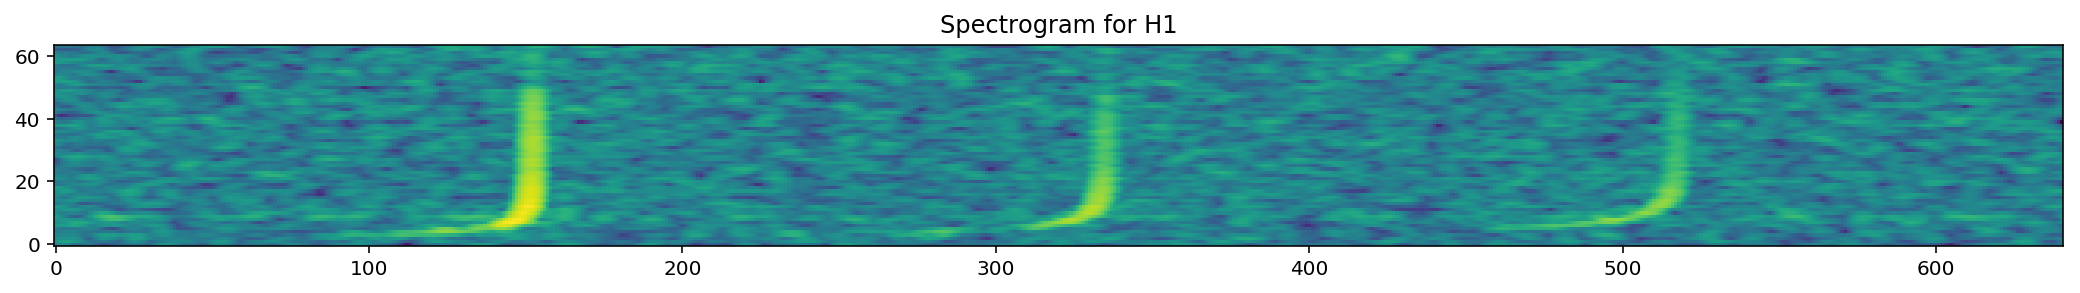

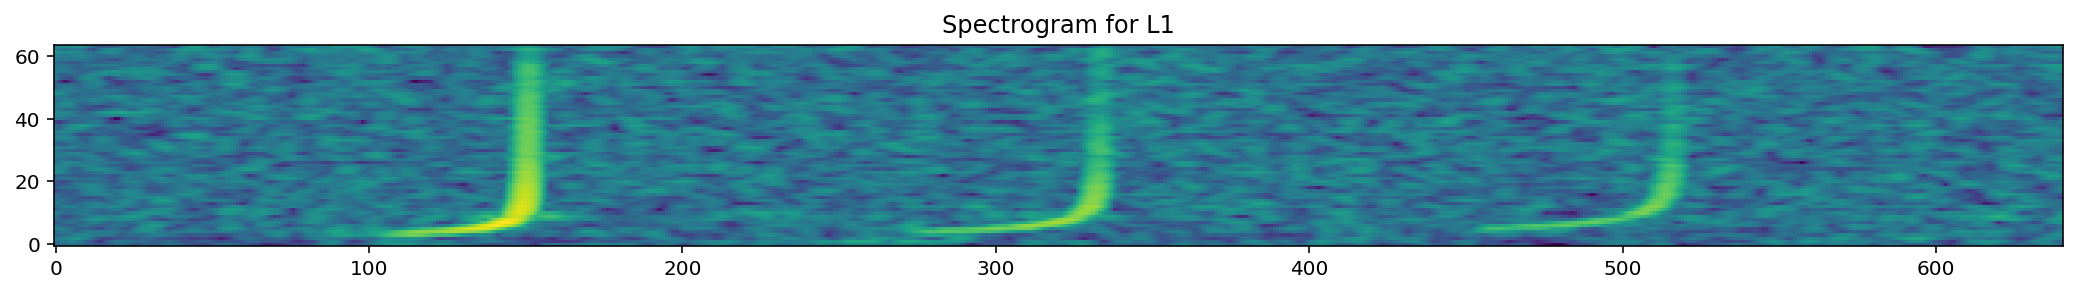

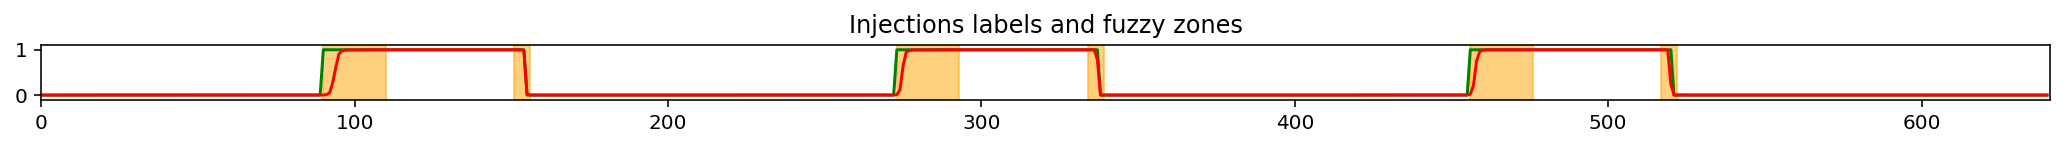

---------------------------------------------------------------------------------------------------------------------


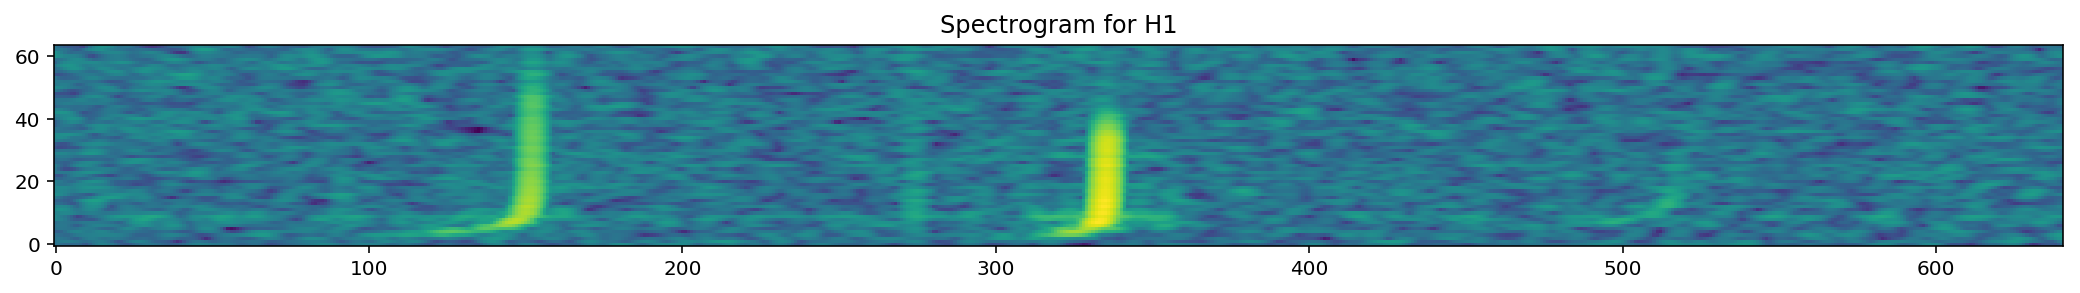

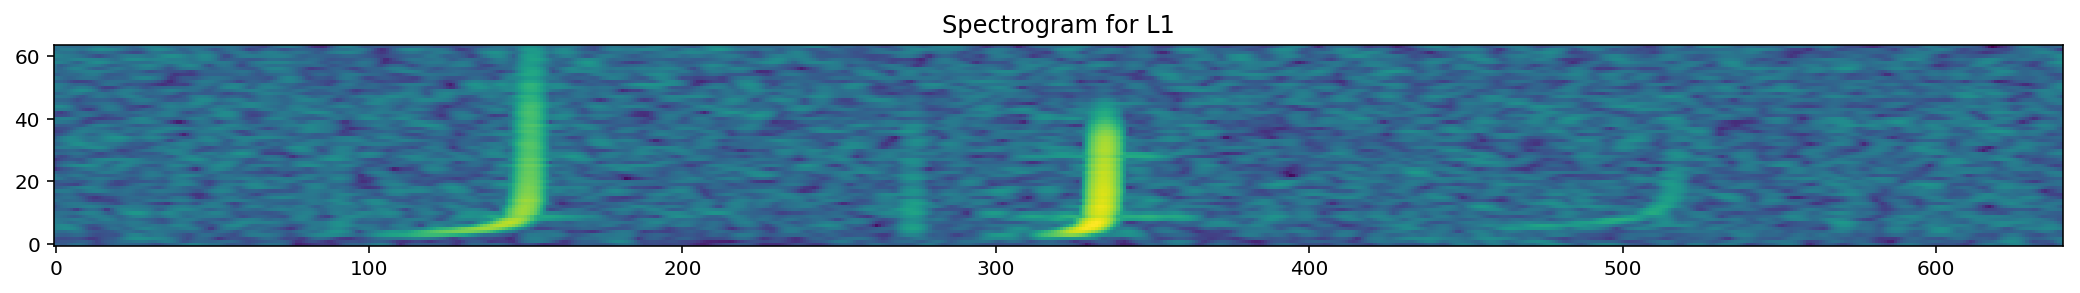

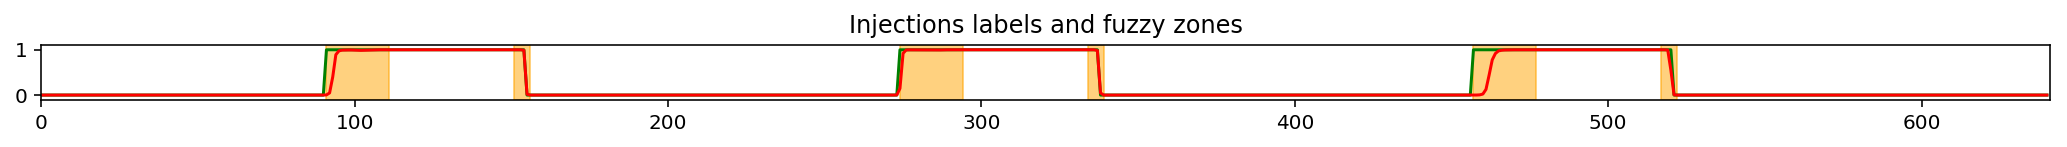

---------------------------------------------------------------------------------------------------------------------


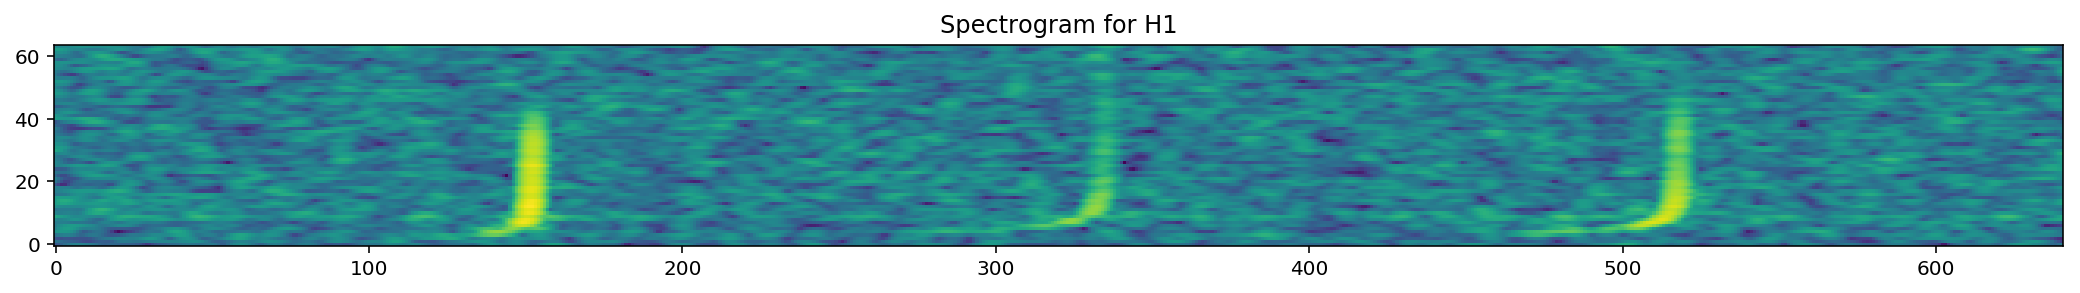

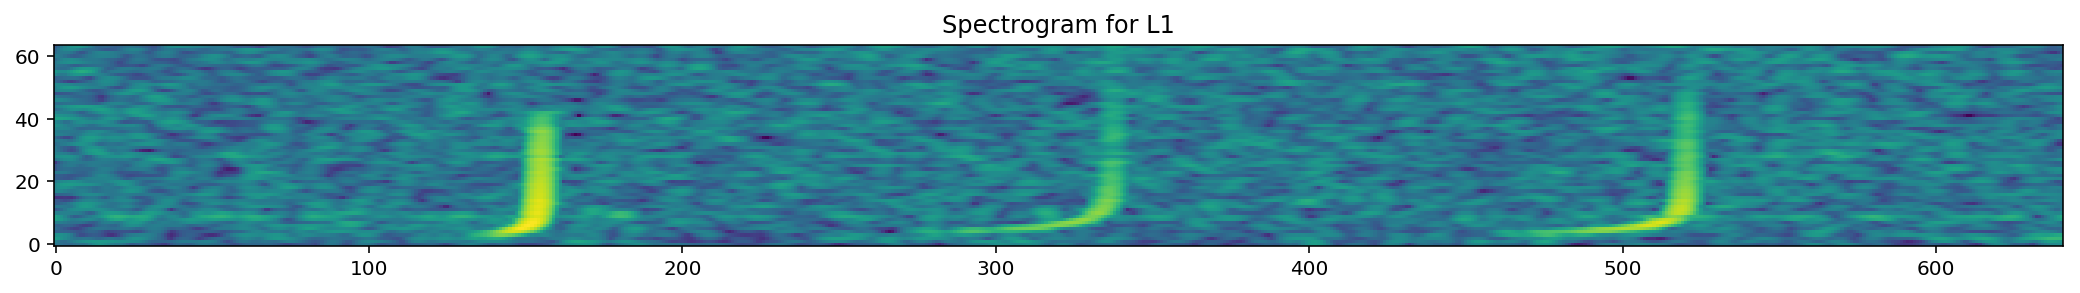

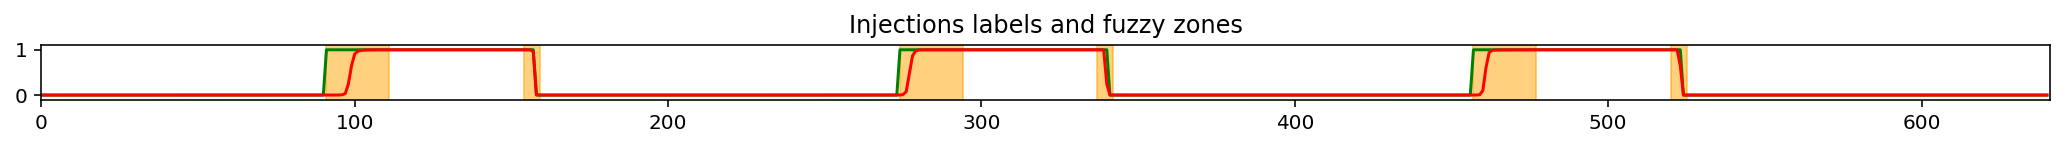

---------------------------------------------------------------------------------------------------------------------


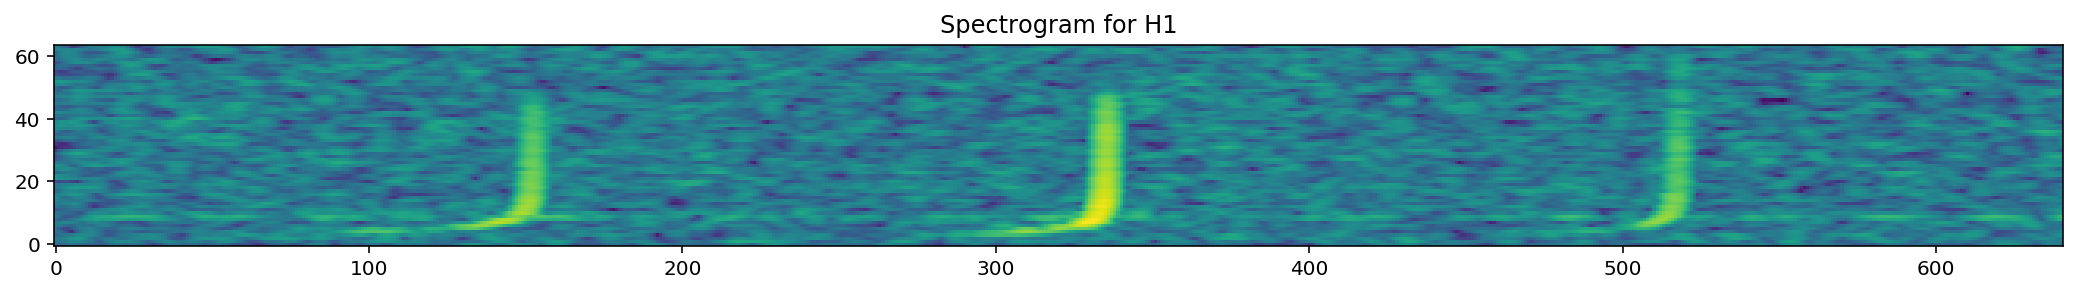

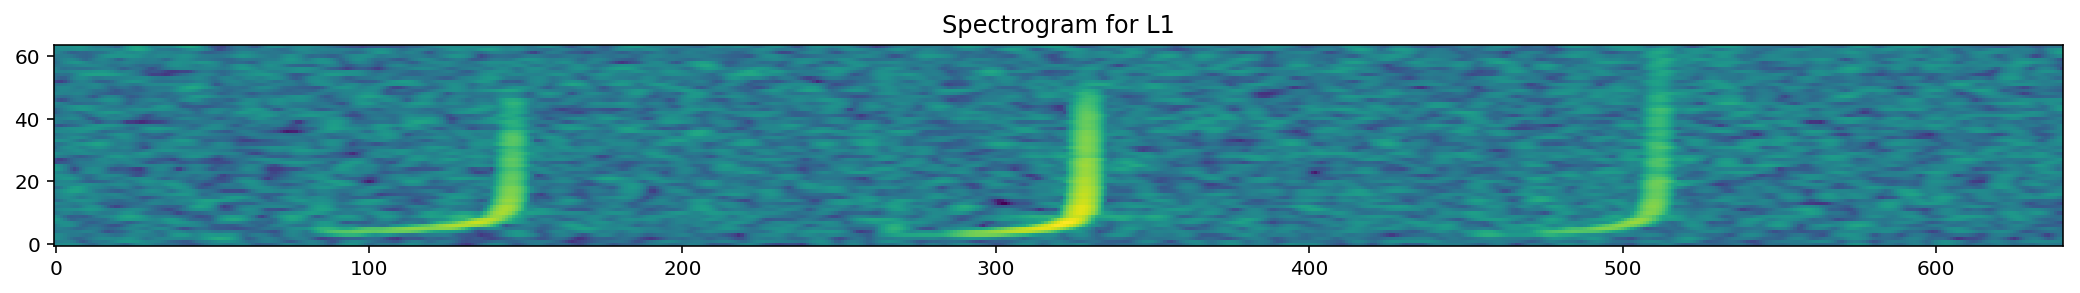

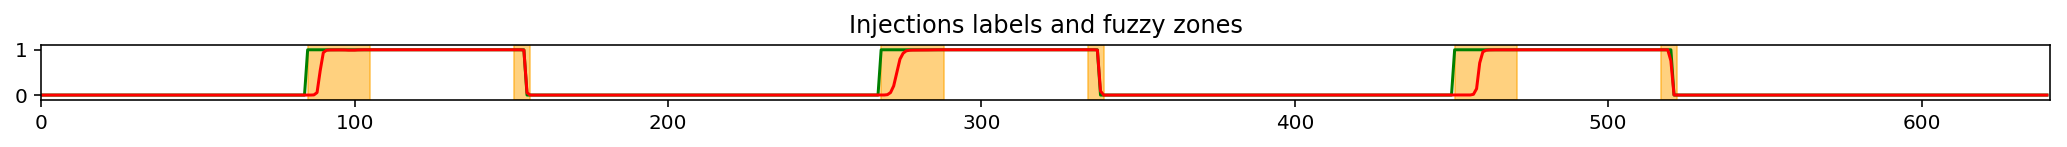

---------------------------------------------------------------------------------------------------------------------


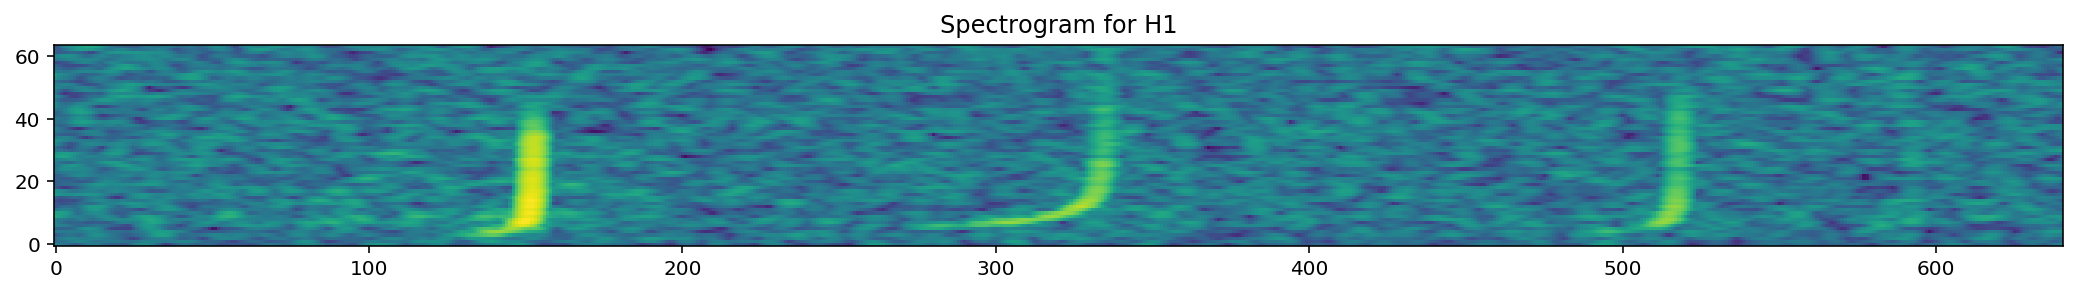

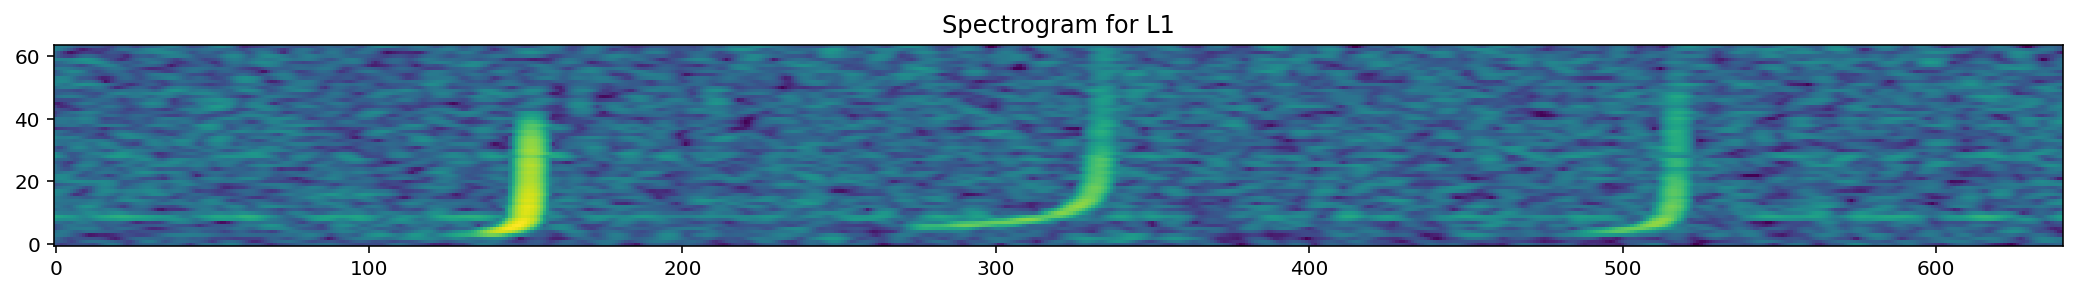

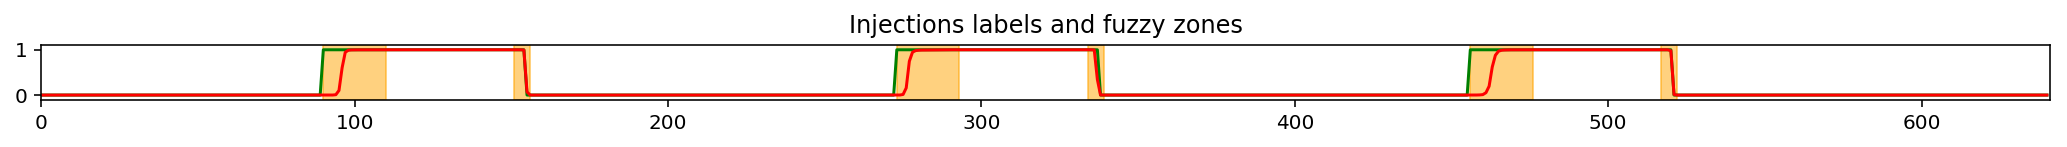

---------------------------------------------------------------------------------------------------------------------


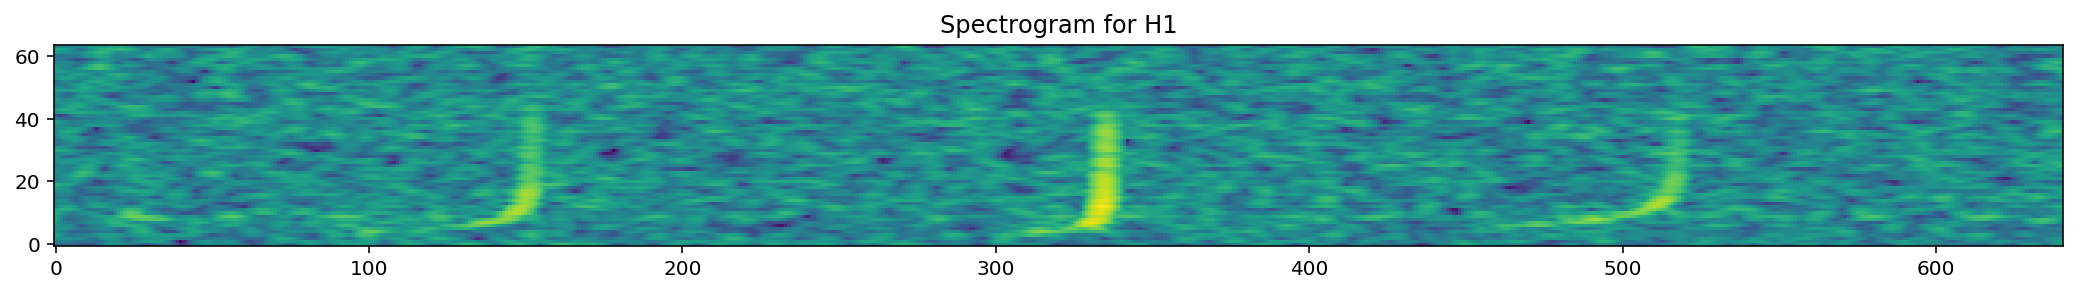

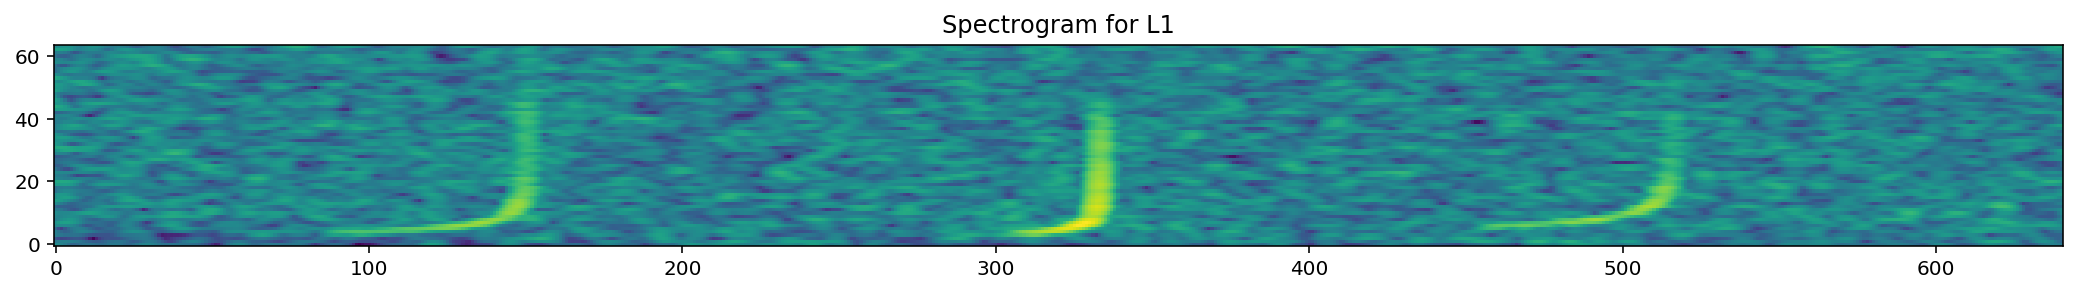

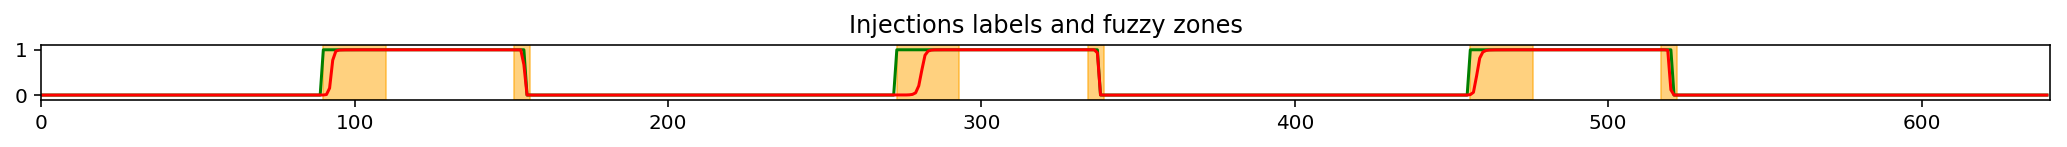

---------------------------------------------------------------------------------------------------------------------


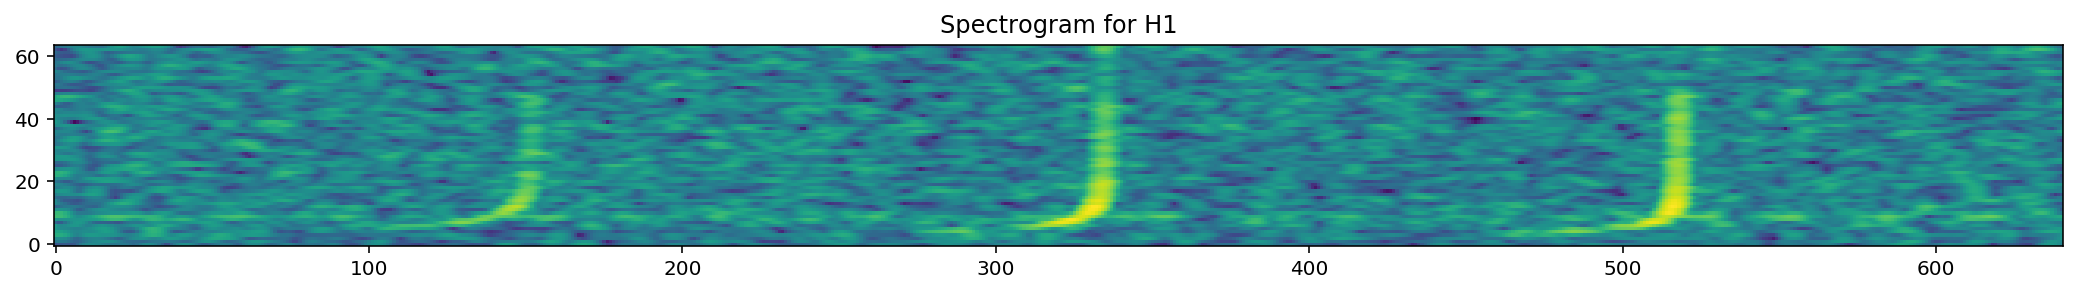

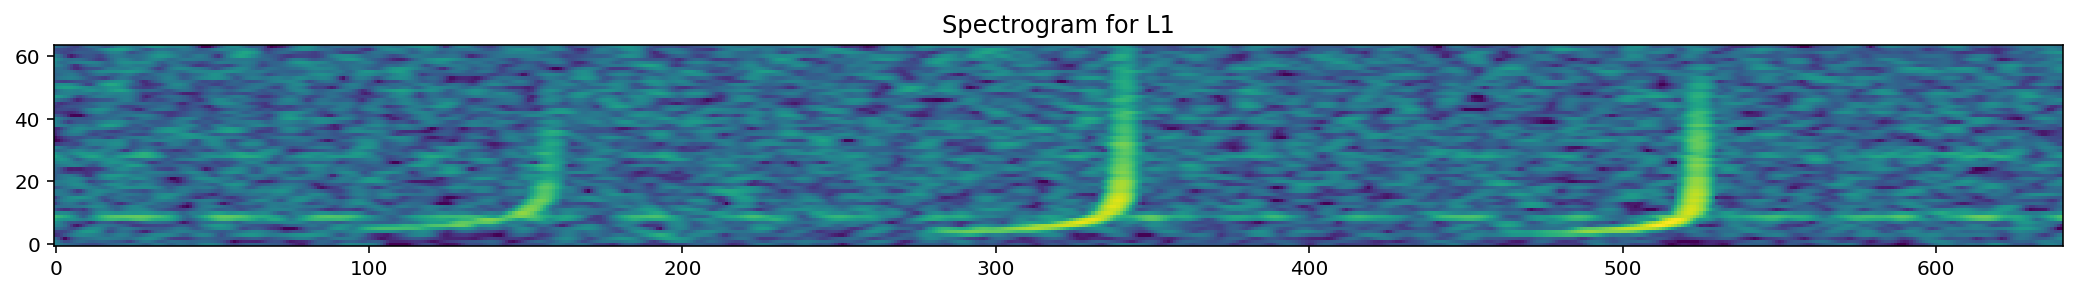

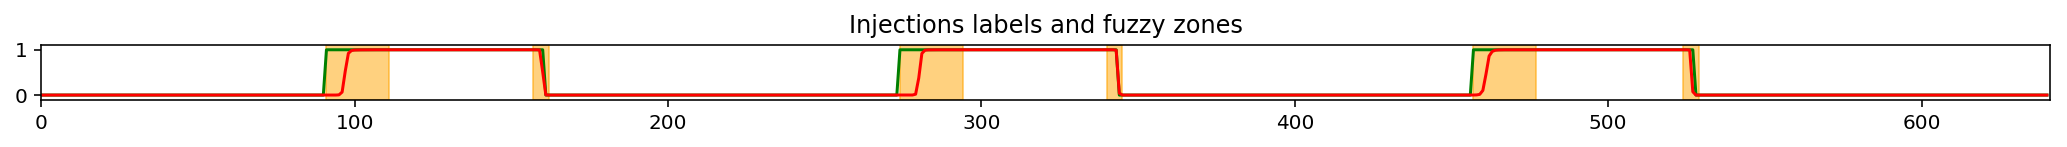

---------------------------------------------------------------------------------------------------------------------


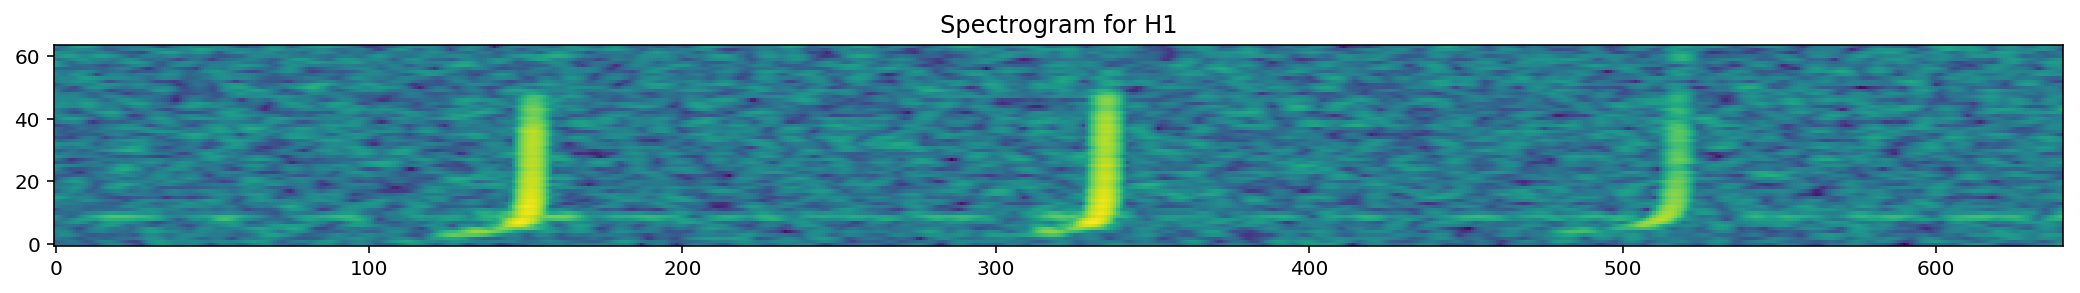

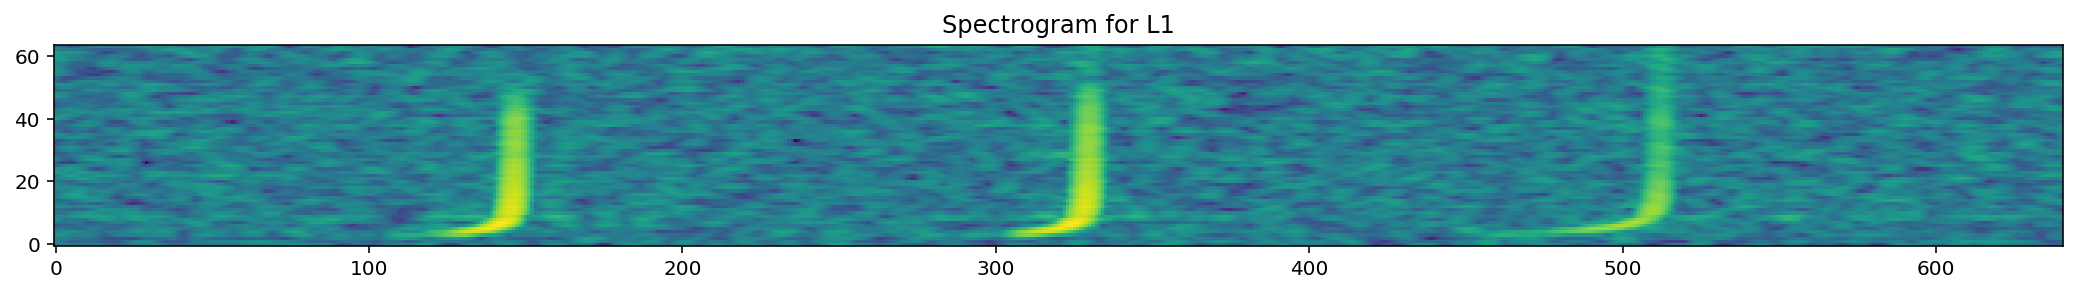

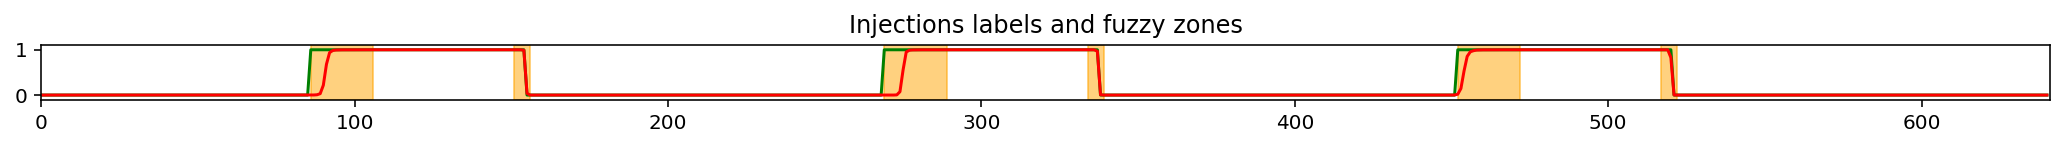

---------------------------------------------------------------------------------------------------------------------


In [41]:
pred = predictions.data.numpy()

for i in range(8):
    
    spectrogram = spectrograms[i]
    label = labels[i]
    prediction = pred[i]
    
    plt.figure(1)
    plt.gcf().set_size_inches(18, 6, forward=True)
    plt.title('Spectrogram for H1')
    plt.imshow(spectrogram[:, :, 0], origin="lower")
    
    plt.figure(2)
    plt.gcf().set_size_inches(18, 6, forward=True)
    plt.title('Spectrogram for L1')
    plt.imshow(spectrogram[:, :, 1], origin="lower")
    
    plt.figure(3)
    plt.gcf().set_size_inches(18, 0.5, forward=True)
    plt.title('Injections labels and fuzzy zones')
    plt.xlim(0, 641)
    plt.ylim(-0.1, 1.1)
    plt.plot(label, color='Green')
    plt.plot(prediction, color='Red')
    
    # Plot the fuzzy zones
    start = None
    in_zone = False
    fuzzy_zones = create_weights(label, start_size=20, end_size=5)
    for i in range(len(fuzzy_zones)):
        if not in_zone:
            if fuzzy_zones[i] == 0:
                start = i
                in_zone = True
        if in_zone:
            if fuzzy_zones[i] == 1:
                plt.axvspan(start, i, alpha=0.5, color='Orange')
                in_zone = False    
    plt.show()
    
    print(117*'-')